In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(1)

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

#### Studying the distribution of variables to detect possible categorical or faulty values

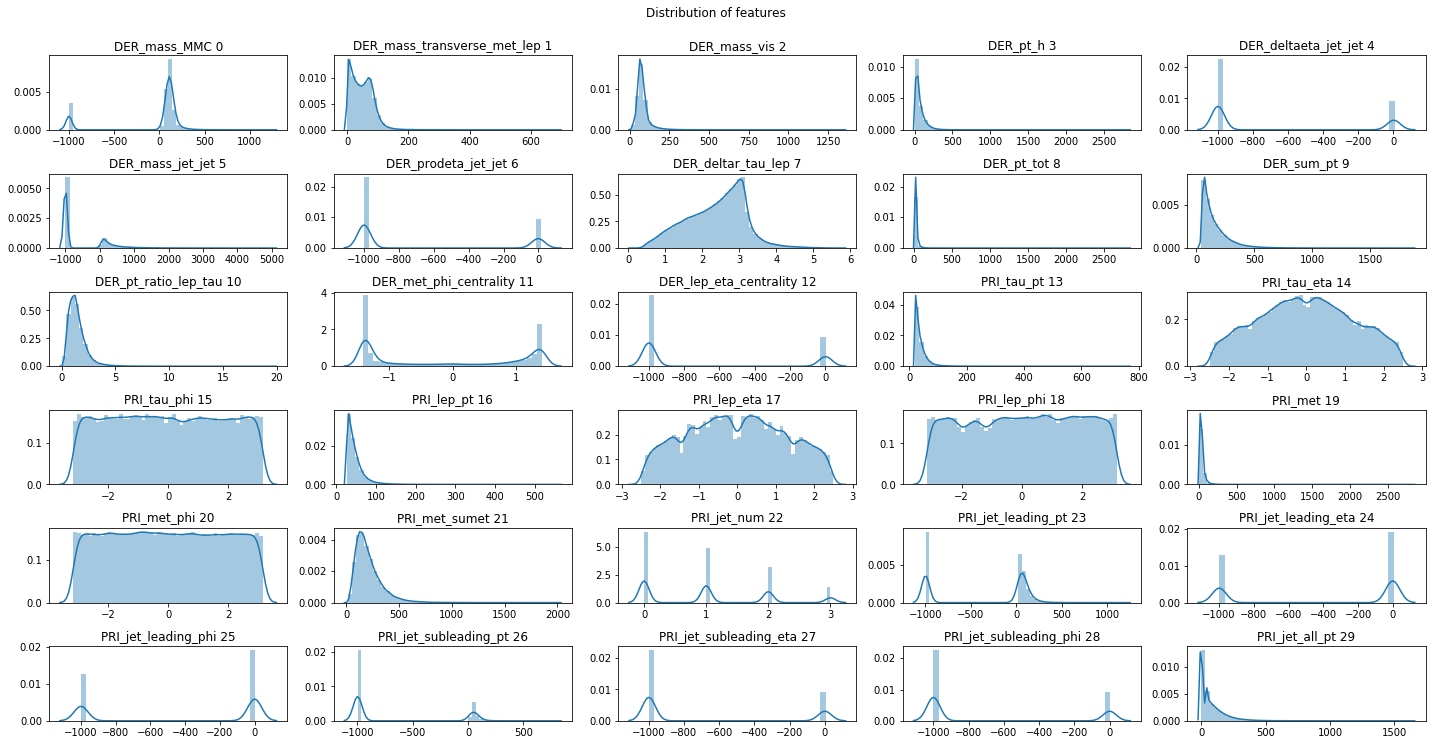

In [6]:
from plots import plot_feature_distribution
plot_feature_distribution(tX, headers, np.arange(len(headers)), "Distribution of features", 5, 6)

As we can see from these plots, different features have different distributions. We can also notice that there seems to be one categorical feature, namely `PRI_jet_num`. This feature is the number of jets used during the experiment. If we look at the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), we can see that some feature are actually affected by the number of jets used.

Features affected by undefined values:
- `DER_mass_MMC` ID=0: undefined if topology of event too far from expected
- `DER_deltaeta_jet_jet` ID=4 : undefined if `PRI_jet_num` <= 1
- `DER_mass_jet_jet` ID=5: undefined if `PRI_jet_num` <= 1
- `DER_prodeta_jet_jet` ID=6: undefined if `PRI_jet_num` <= 1
- `DER_lep_eta_centrality` ID=12: undefined if `PRI_jet_num` <= 1
- `PRI_jet_leading_pt` ID=23: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_eta` ID=24: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_phi` ID=25: undefined if `PRI_jet_num` == 0
- `PRI_jet_subleading_pt` ID=26: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_eta` ID=27: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_phi` ID=28: undefined if `PRI_jet_num` <= 1

Hence, it might be a good idea to have estimators for each number of jets (0, 1, and more than 1).
Also, we can see that features `PRI_tau_phi`, `PRI_lep_phi` and `PRI_met_phi` have an almost uniform distribution, and from the plot below, they seem to have no effect on the label.
However, we will perform feature selection later on as to automatize the elimination of such features, that seem to have no effect.

For now, we will split the dataset into 3 categories:
- tX_0, y_0 : Features and labels for experiments with 0 jets
- tX_1, y_1 : Features and labels for experiments with 1 jet
- tX_2, y_2 : Features and labels for experiments with more than 1 jets


In [4]:
from data_processing import split_dataset

jet_column = 22
tX_0, y_0, tX_1, y_1, tX_2, y_2 = split_dataset(tX, y, jet_col=jet_column) # Split into each category

Now that we have split the dataset, we need to select the columns that are meaningful for each category. For that we have created a function `get_feature_columns` that returns the indices of those columns who have a non null variance.

### Prepare dataset for category 0

In [5]:
from data_processing import prepare_dataset, add_degrees_to_columns

In [6]:
tX_0, y_0, headers_0 = prepare_dataset(tX_0, y_0, headers)

### Feature selection

In [8]:
#y_0_log = y_0.copy()
#y_0_log[np.where(y_0_log == -1)] = 0

In [8]:
from cross_validation import build_k_indices, cross_validation_ridge, cross_validation_ls_gd

In [9]:
from implementations import ridge_regression
from proj1_helpers import compute_accuracy
from utils import split_train_test

def feature_selection(x, y, headers, k_fold, max_degrees, train_ratio):
    max_iters = 1000
    rate = 1e-2
    lambda_ = 1e-2
    results = []
    tx, h = add_degrees_to_columns(x, headers, np.arange(1, x.shape[1]), max_degrees)
    x_train, y_train, x_test, y_test = split_train_test(tx, y, train_ratio)
    k_indices = build_k_indices(y_train, k_fold) # Create k_folds
    
    for i in range(k_fold):
        w, loss_tr, loss_val, acc_val = cross_validation_ls_gd(y_train, x_train, k_indices, i, max_iters, rate, lambda_)
        #w, loss_tr, loss_val, acc_val = cross_validation_ridge(y_train, x_train, k_indices, i, lambda_)
                
        acc_test = compute_accuracy(y_test, x_test, w)
        print(f"Polynomial expansion up to degree {max_degrees}, fold={i}, num_features={tx.shape[1]}, score={acc_test}")
        weights = dict(zip(h, w.reshape(-1)))
        results.append((weights, acc_test))
    return results

In [10]:
res = feature_selection(tX_0, y_0, headers_0, 5, 2, 0.75)

Polynomial expansion up to degree 2, fold=0, num_features=37, score=0.819048000320269
Polynomial expansion up to degree 2, fold=1, num_features=37, score=0.8204491773089395
Polynomial expansion up to degree 2, fold=2, num_features=37, score=0.8195684374874895
Polynomial expansion up to degree 2, fold=3, num_features=37, score=0.8195284038592417
Polynomial expansion up to degree 2, fold=4, num_features=37, score=0.819648504743985


In [11]:
weights = {}
for e in res:
    w = e[0]
    for k, v in w.items():
        if k not in weights:
            weights[k] = np.array([v])
        else:
            weights[k] = np.append(weights[k], v)

#weights_avg = {k: (np.mean(v), np.std(v)) for k, v in weights_avg.items()}

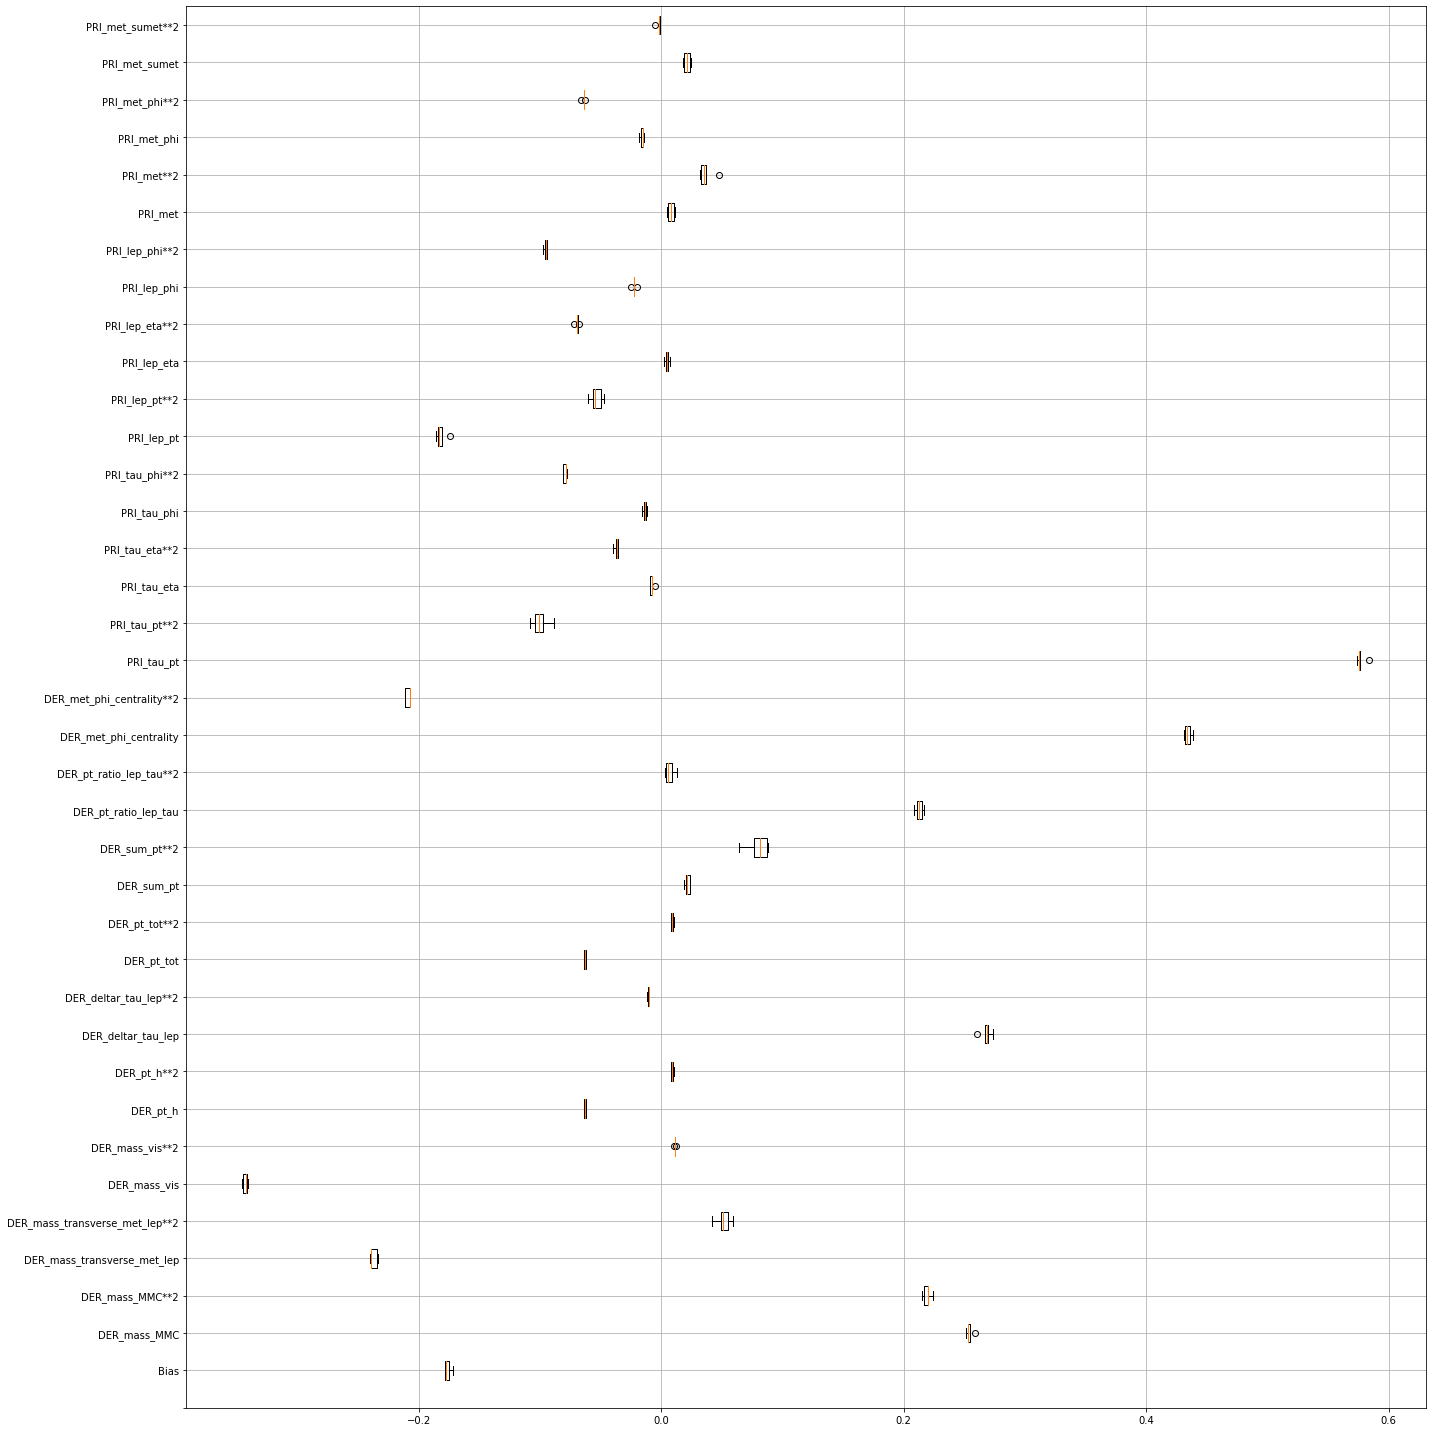

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.grid(True)
f_names, values = list(weights.keys()), list(weights.values())
plt.boxplot(values, vert=False)
plt.yticks(np.arange(len(f_names)+1), [""] + f_names);
#fig.suptitle("Weights for each feature")
#ax.set_ylabel("Weight");
plt.tight_layout()

### Trying other optimizers

### Least Square GD using MSE

In [142]:
max_iters = 1000
rate = 1e-2
initial_w = np.zeros((x_train.shape[1], 1))
weights_ls_gd, loss_ls_gd = least_squares_GD(y_train, x_train, initial_w, max_iters, rate)
score_ls_gd = compute_accuracy(y_test, x_test, weights_ls_gd)
print(f"Least squares GD got score of {score_ls_gd}, loss of {loss_ls_gd}")

Gradient Descent(0/999): loss=0.5
Gradient Descent(100/999): loss=0.30750223035784974
Gradient Descent(200/999): loss=0.28832568513363765
Gradient Descent(300/999): loss=0.28323571173041584
Gradient Descent(400/999): loss=0.2806262178493771
Gradient Descent(500/999): loss=0.2787944112466424
Gradient Descent(600/999): loss=0.27739555942059196
Gradient Descent(700/999): loss=0.2763043247057584
Gradient Descent(800/999): loss=0.2754463788735
Gradient Descent(900/999): loss=0.2747685008053938
Least squares GD got score of 0.8150446374954963, loss of 0.2742305352619737


### Least Square SGD using MSE

In [152]:
max_iters = 10000
rate = 1e-3
initial_w = np.zeros((x_train.shape[1], 1))
weights_ls_sgd, loss_ls_sgd = least_squares_SGD(y_train, x_train, initial_w, max_iters, rate)

score_ls_sgd = compute_accuracy(y_test, x_test, weights_ls_sgd)
print(f"Least squares SGD got score of {score_ls_sgd}, loss of {loss_ls_sgd}")

Gradient Descent(0/9999): loss=0.5
Gradient Descent(1000/9999): loss=0.14597027762574982
Gradient Descent(2000/9999): loss=0.4482521203039793
Gradient Descent(3000/9999): loss=0.21338127155077208
Gradient Descent(4000/9999): loss=0.6916333772064189
Gradient Descent(5000/9999): loss=0.4500845577107704
Gradient Descent(6000/9999): loss=0.8517874138430579
Gradient Descent(7000/9999): loss=0.40218107497981365
Gradient Descent(8000/9999): loss=0.8280241835327067
Gradient Descent(9000/9999): loss=0.03454645345416474
Least squares SGD got score of 0.8178870251010849, loss of 0.2760362317227743


### Ridge Regression

In [12]:
lambda_ = 1e-4
weights_ridge, loss_ridge = ridge_regression(y_train, x_train, lambda_)

score_ridge = compute_accuracy(y_test, x_test, weights_ridge)
print(f"Ridge regression got score of {score_ridge}, loss of {loss_ridge}")

Ridge regression got score of 0.8172064534208735, loss of 0.2717544172094956


### Logistic Regression

In [15]:
y_train_log = y_train.copy()
y_train_log[np.where(y_train_log == -1)] = 0

In [207]:
max_iters = 1000
rate = 1e-5
initial_w = np.ones((x_tr.shape[1], 1))
weights_log, loss_log = logistic_regression(y_train_log, x_tr, initial_w, max_iters, rate)

score_log = compute_accuracy(y_test, x_te, weights_log)
print(f"Logistic regression got score of {score_log}, loss of {loss_log}")

Gradient Descent(0/999): loss=248281.76144006927
Gradient Descent(100/999): loss=30214.329663637676
Gradient Descent(200/999): loss=29721.461273480087
Gradient Descent(300/999): loss=29458.609466137274
Gradient Descent(400/999): loss=29311.69956756374
Gradient Descent(500/999): loss=29228.34969625239
Gradient Descent(600/999): loss=29180.452958681777
Gradient Descent(700/999): loss=29152.62056438643
Gradient Descent(800/999): loss=29136.29875858218
Gradient Descent(900/999): loss=29126.657940950867
Logistic regression got score of 0.8349813843628648, loss of 29120.931533943305


### Regularized Logistic Regression

In [16]:
max_iters = 1000
rate = 1e-5
lambda_ = 0.1
initial_w = np.ones((x_train.shape[1], 1))
weights_log_r, loss_log_r = reg_logistic_regression(y_train_log, x_train,lambda_, initial_w, max_iters, rate)

score_log_r = compute_accuracy(y_test, x_test, weights_log_r)
print(f"Regularized Logistic regression got score of {score_log_r}, loss of {loss_log_r}")

Gradient Descent(0/999): loss=198262.31681309646
Gradient Descent(100/999): loss=30477.802329437698
Gradient Descent(200/999): loss=29862.645796235352
Gradient Descent(300/999): loss=29602.8831950997
Gradient Descent(400/999): loss=29480.900837305682
Gradient Descent(500/999): loss=29420.396804489803
Gradient Descent(600/999): loss=29389.32376861343
Gradient Descent(700/999): loss=29372.983310073676
Gradient Descent(800/999): loss=29364.2489726452
Gradient Descent(900/999): loss=29359.52682109678
Regularized Logistic regression got score of 0.828776171984467, loss of 29356.953171389323


## Generate predictions and save ouput in csv format for submission:

In [230]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [237]:
OUTPUT_PATH = 'test.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(np.ones((tX_test.shape[1], 1)), tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

array([-1., -1., -1., ...,  1.,  1., -1.])